In [1]:
import sys
sys.path.append('../')
from dataset import *
from data_aug import *
import tensorflow as tf
from comparison_model import *

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
data_folder = "..\data\question_1\duels_question_1.csv"

data = prepare_data(data_folder)

In [5]:
# shape = 224

# image1_array, image2_array, labels = prepare_dataset_arrays("data\question_1\Sample_web_green", data, shape)
# save_folder = "data/question_1/Npy"

# image1_array, image2_array, labels = data_aug(image1_array, image2_array, labels, save_folder)

In [6]:
image1_array, image2_array, labels = load_data("../data/question_1/Npy")

In [7]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = prepare_dataset_for_network(image1_array, image2_array, labels)

In [8]:
print(y_train[2000:])

[[0 1]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [9]:
def comparison_siamese_model(input_shape):

    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers:
        layer.trainable = False
    # Create inputs for pairs of images
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)

    # Get embeddings of the images using the shared VGG19 model
    output_1 = base_model(input_1)
    output_2 = base_model(input_2)

    concat = concatenate([output_1, output_2])

    # Classification layer to predict similarity
    flatten = Flatten()(concat)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(concat)
    x = Dropout(0.3)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.1)(x)
    x = Flatten()(x)
    output = Dense(2, activation='sigmoid')(x)

    # Create the complete siamese model
    siamese_model = Model(inputs=[input_1, input_2], outputs=output)
    # Compile the model
    siamese_model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.000001), metrics=['accuracy'])

    # Print model summary
    siamese_model.summary()
    
    return siamese_model

siamese_comparison_model = comparison_siamese_model((224, 224, 3))

history = siamese_comparison_model.fit([X_train[0][2000:], X_train[1][2000:]], y_train[2000:], batch_size=16, epochs=30, validation_data=(X_valid, y_valid))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 512)    20024384    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 7, 7, 1024)   0           vgg19[0][0]                  

In [12]:
# Evaluate the model on the test dataset
loss, accuracy = siamese_comparison_model.evaluate([X_test[0][1000:],X_test[1][1000:] ], y_test[1000:])

print(f"Loss on the test dataset: {loss}")
print(f"Accuracy on the test dataset: {accuracy}")

26/26 [==============================] - 14s 339ms/step - loss: 0.4124 - accuracy: 0.8039
Loss on the test dataset: 0.41239750385284424
Accuracy on the test dataset: 0.8038740754127502


In [13]:
siamese_comparison_model.save("model_dataaug_2000_30E.h5")

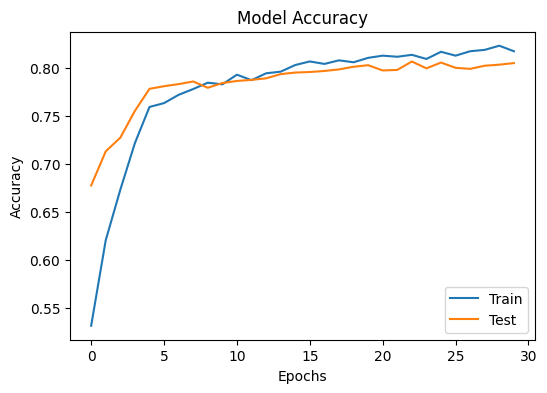

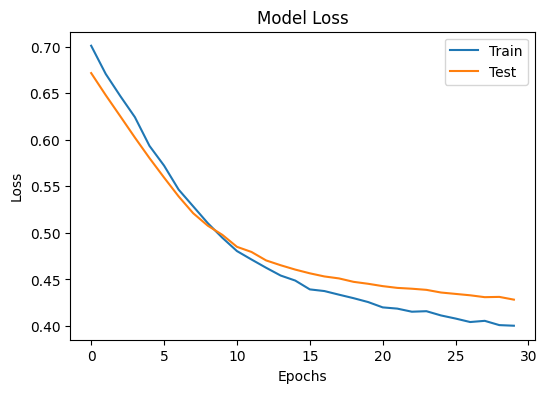

In [14]:
def plot_accuracy_and_loss(history):
    # Plot the accuracy curve
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.savefig('accuracy_plot.png')
    plt.show()

    # Plot the loss curve
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.savefig('loss_plot.png')
    plt.show()
    
plot_accuracy_and_loss(history)